In [26]:
import gym
import numpy as np
from typing import Tuple, List, Any
from tqdm import tqdm
import random
from pdb import set_trace as stop



env = gym.make("Taxi-v3").env

class QAgent:

    def __init__(self, env, alpha, gamma):
        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table = np.zeros([env.observation_space.n, env.action_space.n])

        # hyper-parameters
        self.alpha = alpha
        self.gamma = gamma

    def get_action(self, state):
        """"""
        # stop()
        return np.argmax(self.q_table[state])

    def update_parameters(self, state, action, reward, next_state):
        """"""
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])

        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state, action] = new_value

    def reset(self):
        """
        Sets q-values to zeros, which essentially means the agent does not know
        anything
        """
        self.q_table = np.zeros([self.env.observation_space.n, self.env.action_space.n])



def train(agent,env,n_episodes: int,epsilon: float) -> Tuple[Any, List, List]:
    """
    Trains and agent and returns 3 things:
    - agent object
    - timesteps_per_episode
    - penalties_per_episode
    """
    # For plotting metrics
    timesteps_per_episode = []
    penalties_per_episode = []

    for i in tqdm(range(0, n_episodes)):

        state = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        done = False

        while not done:

            if random.uniform(0, 1) < epsilon:
                # Explore action space
                action = env.action_space.sample()
            else:
                # Exploit learned values
                action = agent.get_action(state)

            next_state, reward, done, info = env.step(action)

            agent.update_parameters(state, action, reward, next_state)

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1

        timesteps_per_episode.append(epochs)
        penalties_per_episode.append(penalties)

    return agent, timesteps_per_episode, penalties_per_episode



def train_with_ep_decay(agent,env,n_episodes: int,epsilon: float) -> Tuple[Any, List, List]:
    """
    Trains and agent and returns 3 things:
    - agent object
    - timesteps_per_episode
    - penalties_per_episode
    """
    # For plotting metrics
    timesteps_per_episode = []
    penalties_per_episode = []

    for i in tqdm(range(0, n_episodes)):
        if n_episodes % 10 == 0:
            epsilon = epsilon * 0.95

        state = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        done = False

        while not done:

            if random.uniform(0, 1) < epsilon:
                # Explore action space
                action = env.action_space.sample()
            else:
                # Exploit learned values
                action = agent.get_action(state)

            next_state, reward, done, info = env.step(action)

            agent.update_parameters(state, action, reward, next_state)

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1

        timesteps_per_episode.append(epochs)
        penalties_per_episode.append(penalties)

    return agent, timesteps_per_episode, penalties_per_episode


Q-learning gives us a method to compute optimal q-values. But, what about the hyper-parameters alpha , gamma and epsilon ?

I chose them for you, rather arbitrarily. But in practice, you will need to tune them for your RL problems.
Let’s explore their impact on learning to get a better intuition of what is going on.

## HYPERPARAMETER TUNING

Q-learning gives us a method to compute optimal q-values. But, what about the hyper-parameters alpha , gamma and epsilon ?

I chose them for you, rather arbitrarily. But in practice, you will need to tune them for your RL problems.
Let’s explore their impact on learning to get a better intuition of what is going on.

Let’s train our q-agent using different values for `alpha (learning rate)` and `gamma (discount factor)`. As for `epsilon` we keep it at 10%.

In [16]:
# hyper-parameters
# RL problems are full of these hyper-parameters.
# For the moment, trust me when I set these values.
# We will later play with these and see how they impact learning.

alpha = 0.1 # learning rate
gamma = 0.6 # discount factor
epsilon = 0.1 # exploration vs exploitation prob

In [6]:
# TRAINING LOOP

import pandas as pd

# hyper-parameters
alphas = [0.01, 0.1, 1]
gammas = [0.1, 0.6, 0.9]
epsilon = 0.1 # exploration vs exploitation prob. let's start with a constant probability of 10%.

n_episodes = 1000

results = pd.DataFrame()

for alpha in alphas:
    for gamma in gammas:
        
        print(f'alpha: {alpha}, gamma: {gamma}')

        agent = QAgent(env, alpha, gamma)
        
        _, timesteps, penalties = train(agent, env,n_episodes, epsilon)
        
        # collect timesteps and penalties for this pair
        # of hyper-parameters (alpha, gamma)
        results_ = pd.DataFrame()
        results_['timesteps'] = timesteps
        results_['penalties'] = penalties
        results_['alpha'] = alpha
        results_['gamma'] = gamma
        results = pd.concat([results, results_])

# index -> episode
results = results.reset_index().rename(columns={'index': 'episode'})

# add column with the 2 hyper-parameters
results['hyperparameters'] = [f'alpha={a}, gamma={g}'for (a, g) in zip(results['alpha'], results['gamma'])]

alpha: 0.01, gamma: 0.1


100%|██████████| 1000/1000 [00:42<00:00, 23.56it/s]


alpha: 0.01, gamma: 0.6


100%|██████████| 1000/1000 [00:23<00:00, 42.23it/s]


alpha: 0.01, gamma: 0.9


100%|██████████| 1000/1000 [00:18<00:00, 55.42it/s]


alpha: 0.1, gamma: 0.1


100%|██████████| 1000/1000 [00:14<00:00, 70.49it/s]


alpha: 0.1, gamma: 0.6


100%|██████████| 1000/1000 [00:06<00:00, 147.16it/s]


alpha: 0.1, gamma: 0.9


100%|██████████| 1000/1000 [00:04<00:00, 211.12it/s]


alpha: 1, gamma: 0.1


100%|██████████| 1000/1000 [00:01<00:00, 561.24it/s]


alpha: 1, gamma: 0.6


100%|██████████| 1000/1000 [00:02<00:00, 486.46it/s]


alpha: 1, gamma: 0.9


100%|██████████| 1000/1000 [00:02<00:00, 454.51it/s]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/distutils/ccompiler.py:17: DeprecationWarning: The distutils.sysconfig module is deprecated, use sysconfig instead
  from distutils.sysconfig import customize_compiler
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='episode', ylabel='timesteps'>

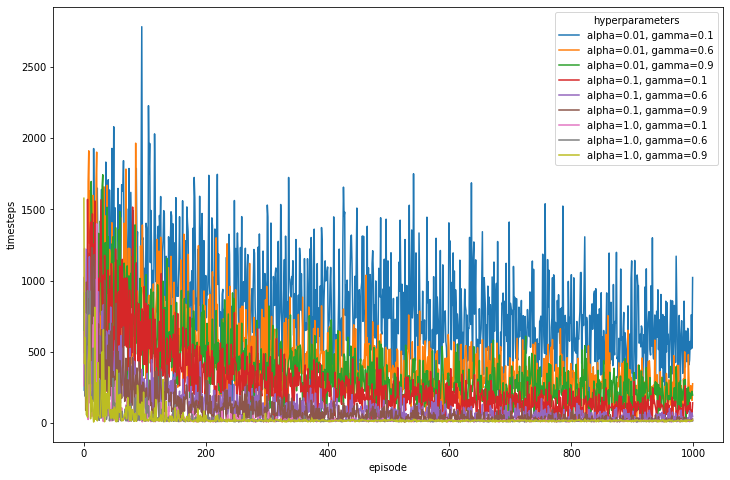

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'timesteps',hue='hyperparameters', data=results)

The graph looks artsy-fartsy, but a bit too noisy 😵.

Something you can observe though is that when alpha = 0.01 the learning is slower. `alpha (learning rate)` controls how much we update the q-values in each iteration. Too small of a value implies slower learning.

Let’s discard `alpha = 0.01` and do 10 runs of training for each combination of hyper-parameters. We average the timestepsfor each episode number, from 1 to 1000, using these 10 runs.

In [27]:
def train_many_runs(agent,env,n_episodes: int,epsilon: float,n_runs: int,) -> Tuple[List, List]:
    """
    Calls 'train' many times, stores results and averages them out.
    """
    timesteps = np.zeros(shape=(n_runs, n_episodes))
    penalties = np.zeros(shape=(n_runs, n_episodes))

    for i in range(0, n_runs):

        agent.reset()

        _, timesteps[i, :], penalties[i, :] = train(
            agent, env, n_episodes, epsilon
        )
    timesteps = np.mean(timesteps, axis=0).tolist()
    penalties = np.mean(penalties, axis=0).tolist()

    return timesteps, penalties

def train_many_runs_with_decay(agent,env,n_episodes: int,epsilon: float,n_runs: int,) -> Tuple[List, List]:
    """
    Calls 'train' many times, stores results and averages them out.
    """
    timesteps = np.zeros(shape=(n_runs, n_episodes))
    penalties = np.zeros(shape=(n_runs, n_episodes))

    for i in range(0, n_runs):

        agent.reset()

        _, timesteps[i, :], penalties[i, :] = train_with_ep_decay(
            agent, env, n_episodes, epsilon
        )
    timesteps = np.mean(timesteps, axis=0).tolist()
    penalties = np.mean(penalties, axis=0).tolist()

    return timesteps, penalties

In [21]:
alphas = [0.1, 1]
gammas = [0.1, 0.6, 0.9]

epsilon = 0.1
n_episodes = 1000
n_runs = 10

results = pd.DataFrame()
for alpha in alphas:
    for gamma in gammas:
        
        print(f'alpha: {alpha}, gamma: {gamma}')
        agent = QAgent(env, alpha, gamma)
        
        timesteps, penalties = train_many_runs(agent,env,n_episodes,epsilon,n_runs)
        
        # collect timesteps and penalties for this pair of
        # hyper-parameters (alpha, gamma)
        results_ = pd.DataFrame()
        results_['timesteps'] = timesteps
        results_['penalties'] = penalties
        results_['alpha'] = alpha
        results_['gamma'] = gamma
        results = pd.concat([results, results_])

# index -> episode
results = results.reset_index().rename(
    columns={'index': 'episode'})

results['hyperparameters'] = [
    f'alpha={a}, gamma={g}'
    for (a, g) in zip(results['alpha'], results['gamma'])]

alpha: 0.1, gamma: 0.1


100%|██████████| 1000/1000 [00:13<00:00, 71.51it/s]


alpha: 0.1, gamma: 0.6


100%|██████████| 1000/1000 [00:06<00:00, 146.62it/s]


alpha: 0.1, gamma: 0.9


100%|██████████| 1000/1000 [00:05<00:00, 177.90it/s]


alpha: 1, gamma: 0.1


100%|██████████| 1000/1000 [00:01<00:00, 642.98it/s]


alpha: 1, gamma: 0.6


100%|██████████| 1000/1000 [00:01<00:00, 566.02it/s]


alpha: 1, gamma: 0.9


100%|██████████| 1000/1000 [00:01<00:00, 652.83it/s]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='episode', ylabel='timesteps'>

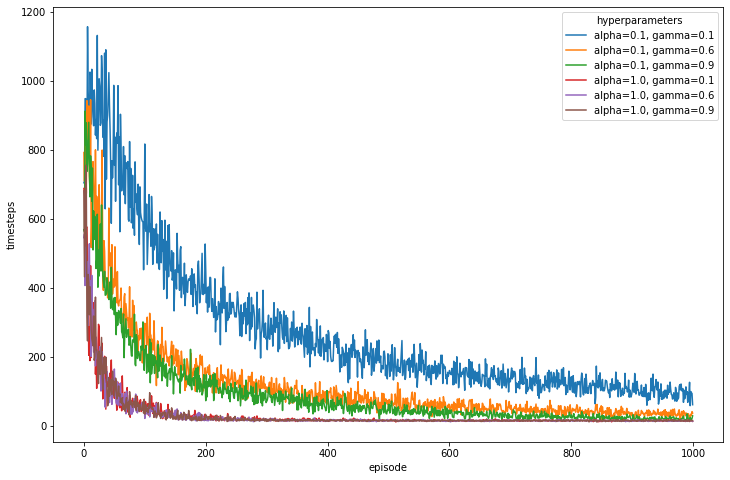

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'timesteps',hue='hyperparameters', data=results)

It looks like `alpha = 1.0` is the value that works best, while gamma seems to have less of an impact.

Congratulations! You have tuned your first learning rate in this course 🥳

Tunning hyper-parameters can be time-consuming and tedious. There are excellent libraries to automate the manual process we just followed, like Optuna, but this is something we will play with later in the course. For the time being, enjoy the speed-up in training we have just found.

Wait, what happens with this `epsilon = 10%` that I told you to trust me on?

Is the current 10% value the best?

Let’s check it ourselves.

We take the best alpha and gamma we found, i.e.

`alpha = 1.0`
`gamma = 0.9` (we could have taken 0.1 or 0.6 too)

And train with different
`epsilons = [0.01, 0.1, 0.9]`

In [23]:
# best hyper-parameters so far
alpha = 1.0
gamma = 0.9

epsilons = [0.01, 0.10, 0.9]
n_runs = 10
n_episodes = 200

results = pd.DataFrame()
for epsilon in epsilons:
        
    print(f'epsilon: {epsilon}')
    agent = QAgent(env, alpha, gamma)

    timesteps, penalties = train_many_runs(agent,
                                           env,
                                           n_episodes,
                                           epsilon,
                                           n_runs)

    # collect timesteps and penalties for this pair of
    # hyper-parameters (alpha, gamma)
    results_ = pd.DataFrame()
    results_['timesteps'] = timesteps
    results_['penalties'] = penalties
    results_['epsilon'] = epsilon
    results = pd.concat([results, results_])

# index -> episode
results = results.reset_index().rename(columns={'index': 'episode'})

epsilon: 0.01


100%|██████████| 200/200 [00:01<00:00, 125.81it/s]


epsilon: 0.1


100%|██████████| 200/200 [00:01<00:00, 161.29it/s]


epsilon: 0.9


100%|██████████| 200/200 [00:05<00:00, 39.75it/s]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


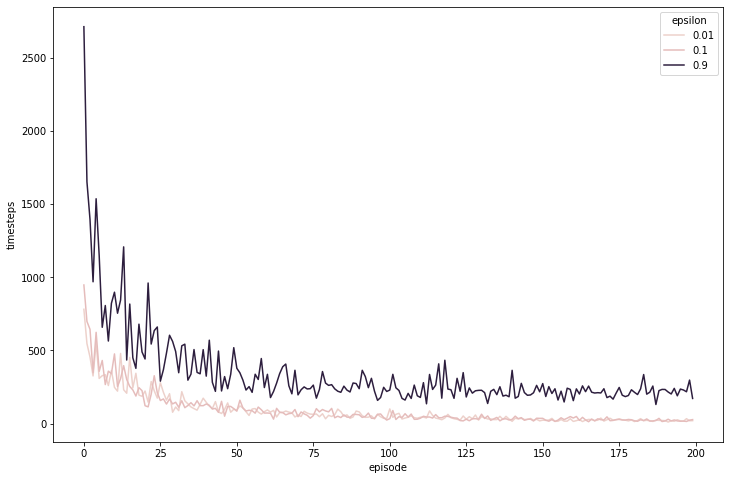

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='episode', ylabel='penalties'>

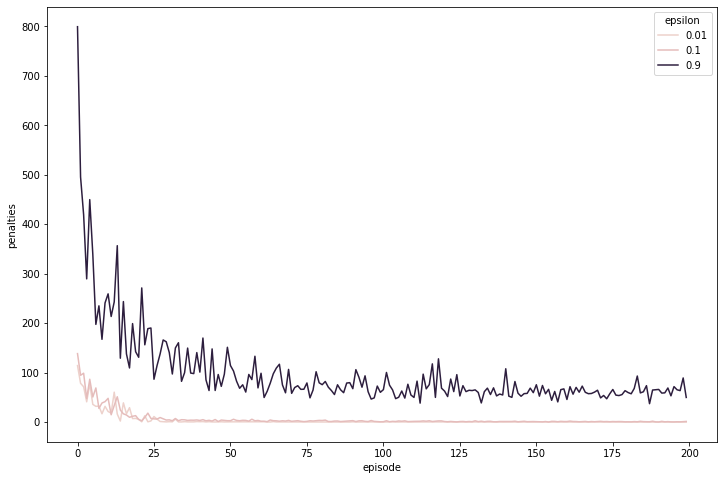

In [24]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'timesteps', hue='epsilon', data=results)
plt.show()

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'penalties', hue='epsilon', data=results)

As you can see, both `epsilon = 0.01` and `epsilon = 0.1` seem to work equally well, as they strike the right balance between exploration and exploitation.

On the other side, `epsilon = 0.9` is too large of a value, causing “too much” randomness during training, and preventing our q-matrix to converge to the optimal one. Observe how the performance plateaus at around 250 timesteps per episode.

In general, the best strategy to choose the epsilon hyper-parameter is progressive epsilon-decay. That is, at the beginning of training, when the agent is very uncertain about its q-value estimation, it is best to visit as many states as possible, and for that, a large epsilon is great (e.g. 50%)

As training progresses, and the agent refines its q-value estimation, it is no longer optimal to explore that much. Instead, by decreasing epsilon the agent can learn to perfect and fine-tune the q-values, to make them converge faster to the optimal ones. Too large of an epsilon can cause convergence issues as we see for `epsilon = 0.9 `.

We will be tunning epsilons along the course, so I will not insist too much for the moment. Again, enjoy what we have done today. It is pretty remarkable.

In [28]:
# best hyper-parameters so far
alpha = 1.0
gamma = 0.9

epsilons = [0.01, 0.10, 0.9]
n_runs = 10
n_episodes = 200

results = pd.DataFrame()
for epsilon in epsilons:
        
    print(f'epsilon: {epsilon}')
    agent = QAgent(env, alpha, gamma)

    timesteps, penalties = train_many_runs_with_decay(agent,
                                           env,
                                           n_episodes,
                                           epsilon,
                                           n_runs)

    # collect timesteps and penalties for this pair of
    # hyper-parameters (alpha, gamma)
    results_ = pd.DataFrame()
    results_['timesteps'] = timesteps
    results_['penalties'] = penalties
    results_['epsilon'] = epsilon
    results = pd.concat([results, results_])

# index -> episode
results = results.reset_index().rename(columns={'index': 'episode'})

epsilon: 0.01


100%|██████████| 200/200 [00:01<00:00, 144.92it/s]


epsilon: 0.1


100%|██████████| 200/200 [00:00<00:00, 226.04it/s]


epsilon: 0.9


100%|██████████| 200/200 [00:01<00:00, 145.28it/s]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


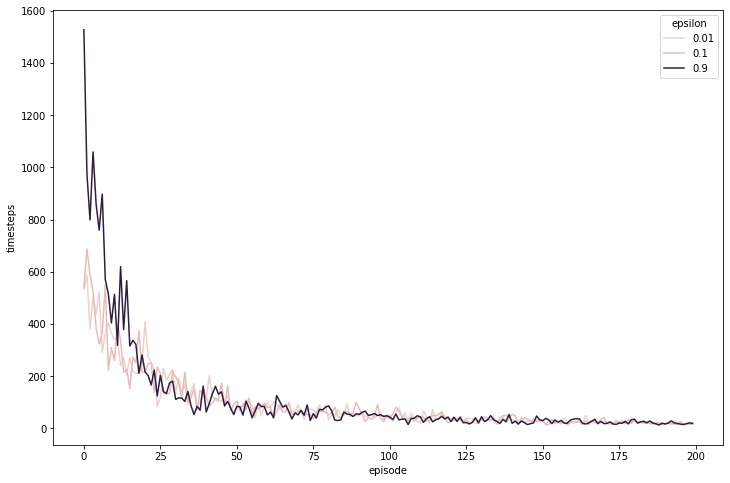

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='episode', ylabel='penalties'>

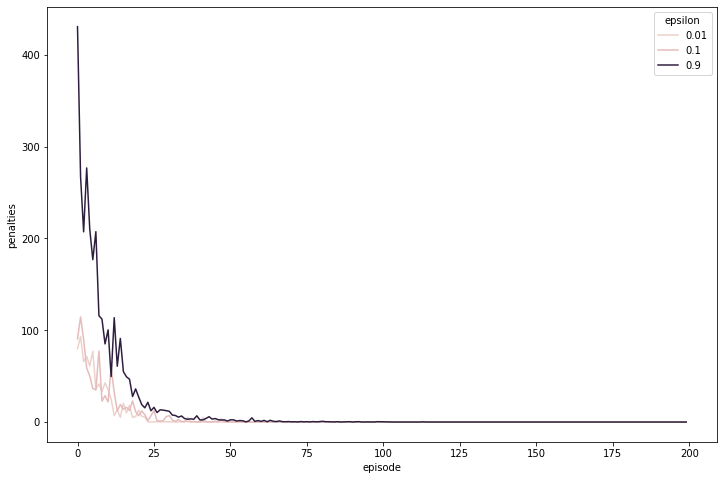

In [29]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'timesteps', hue='epsilon', data=results)
plt.show()

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'penalties', hue='epsilon', data=results)

In [30]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4
